$$
J = \int\limits_{-\infty}^\infty e^{-x^2}dx 
$$

let's consider 
$$ I = \int\limits_{0}^\infty e^{-x^2}dx $$

Because of the symmetry of the integral and the positive area of values of the integrand function, we can conclude that:

$$
J = \int\limits_{-\infty}^\infty e^{-x^2}dx = 2 \int\limits_{0}^\infty e^{-x^2}dx $$


$$
I^2 = \int\limits_0^\infty e^{-x^2}dx \int\limits_0^\infty e^{-y^2}dy = \int\limits_0^\infty \int\limits_0^\infty e^{-(x^2+y^2)}dxdy
$$

$$
dS = dxdy = rd\varphi dr
$$
$$
x = r\cos\varphi
$$
$$
y = r\sin\varphi
$$
$$
x^2+y^2 = r^2
$$

$$
I^2 = \int\limits_0^\infty \int\limits_0^\infty e^{-(x^2+y^2)}dxdy = \int\limits_0^\frac{\pi}{2} \int\limits_0^\infty e^{-r^2}rdrd\varphi = \int\limits_0^\frac{\pi}{2} d\varphi \int\limits_0^\infty e^{-r^2}rdr = 
\int\limits_0^\frac{\pi}{2} d\varphi \int\limits_0^\infty e^{-r^2}\frac{1}{2}d(r^2)=\frac{1}{2}\int\limits_0^\frac{\pi}{2} d\varphi = \frac{\pi}{4}
$$

$$
I = \sqrt\frac{\pi}{4} = \frac{\sqrt{\pi}}{2}
$$

$$
J = \int\limits_{-\infty}^\infty e^{-x^2}dx = \sqrt{\pi}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
%matplotlib inline

true_val = np.sqrt(np.pi)
print('Analytical result: I =', true_val)

Analytical result: I = 1.7724538509055159


In [2]:
def func(x):
    return np.exp(-(x**2))

def integral(fun,a,b,N):
    res = list()
    h = (b-a)/N
    x = np.arange(a,b+h,h)
    
    for x_i in x:
        res.append(fun(x_i))
    
    result = h*(np.sum(res[1:-1])+(res[0]+res[-1])/2)
    return result, x, res

In [3]:
result, x, res = integral(func,-10**3,10**3,5*10**5)
print("Computed result: I =",result)

Computed result: I = 1.7724538508970529


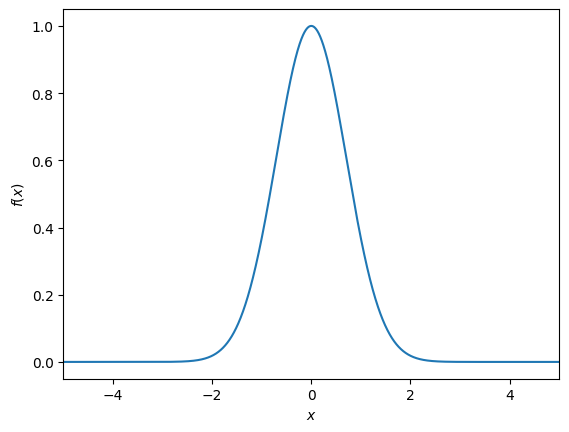

In [4]:
plt.plot(x,res)
plt.xlim(-5,5)
plt.xlabel("$x$")
plt.ylabel("$f(x)$");

In [8]:
%%writefile integral_parallelv2.py
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def func(x):
    return np.exp(-(x**2))

a = -10**3
b = 10**3
N = 10**5
h = (b-a)/N

steps = N//size
l = rank*steps
r = (rank+1)*steps

def integral(fun, a, b, N, l, r):
    res = list()
    h = (b-a)/N
    x = np.arange(a,b+h,h)
    
    for x_i in x[l:r]:
        res.append(fun(x_i))
    
    result = h*(np.sum(res[1:-1])+(res[0]+res[-1])/2)
    return result

result = integral(func, a, b, N, l, r)
#print(f"process number {rank} and result {result}")

data = comm.gather(result, root=0)

if rank == 0:
    print(sum(data))

Overwriting integral_parallelv2.py


In [10]:
n = np.arange(1,9)
results = list()

for i in n:
    a = %timeit -o -r 2 !mpiexec -np {i} python integral_parallelv2.py
    results.append(a.best)

1.7724538509071277
1.7724538509071277
1.7724538509071277
615 ms ± 6.54 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.7524578501075985
1.7524578501075985
1.7524578501075985
616 ms ± 14.2 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.7724538509071284
1.7724538509071284
1.7724538509071284
733 ms ± 15.3 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.7524578501075987
1.7524578501075987
1.7524578501075987
905 ms ± 23 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.7724538509071281
1.7724538509071281
1.7724538509071281
1.21 s ± 21.6 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.752505773393456
1.752505773393456
1.752505773393456
1.36 s ± 54.5 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.7724538509071281
1.7724538509071281
1.7724538509071281
1.43 s ± 1.61 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1.7524578501075985
1.7524578501075985
1.7524578501075985
1.64 s ± 19.1 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


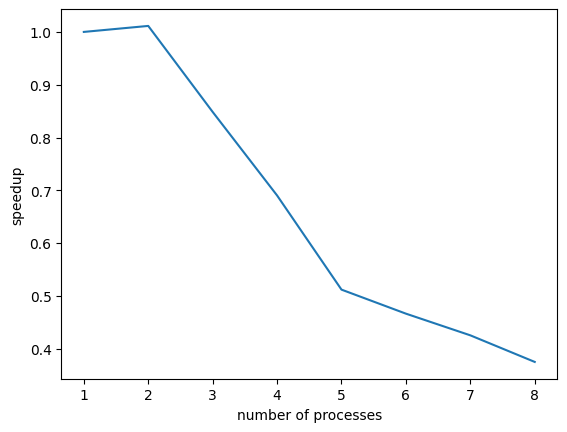

In [11]:
res = list(map(lambda x: results[0]/x, results))
plt.plot(n,res)
plt.xlabel("number of processes")
plt.ylabel("speedup");

In [12]:
N = np.logspace(0,7,20)

In [13]:
error = list()
for size in N:
    computed,_,_ = integral(func,-10**3,10**3,size)
    error.append(abs((true_val-computed)/true_val*100))

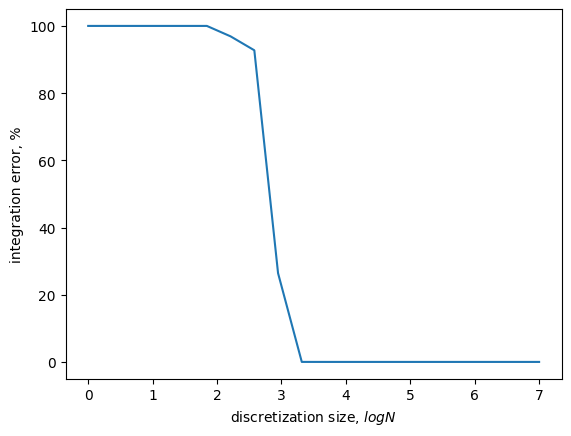

In [14]:
plt.plot(np.log10(N),error)
plt.xlabel("discretization size, $logN$")
plt.ylabel('integration error, %');